In [1]:
pip install -q *.whl numpy matplotlib osparc_filecomms pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pathlib as pl
import json
import zipfile

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas

import osparc
import osparc_client
import osparc_client.models.file

import tools.maps
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [4]:
TEST_INPUT_FILES_DIR = 'example_r20211130-ivadomed_dataset'

In [3]:
osparc_cfg = osparc.Configuration(host=os.environ["OSPARC_API_HOST"],
                                  username=os.environ["OSPARC_API_KEY"],
                                  password=os.environ["OSPARC_API_SECRET"])
output_dir_path = pl.Path(os.environ['DY_SIDECAR_PATH_OUTPUTS'])
output1_dir_path = output_dir_path / 'output_1'

input_dir_path = pl.Path(os.environ['DY_SIDECAR_PATH_INPUTS'])
input1_dir_path = input_dir_path / 'input_1'

map_outputs_file_path = pl.Path('map_outputs.json')

In [5]:
input_images_dir_path = pl.Path(TEST_INPUT_FILES_DIR)
input_images_paths = list(input_images_dir_path.glob('*.png'))
input_metadata_paths = [path.with_suffix('.json') for path in input_images_paths]

In [6]:
def show_input_files(file_list):
    fig, axes = plt.subplots(1, len(file_list), figsize=(20,10))
    for local_file_path, ax in zip(file_list, axes):
        ax.imshow(mpimg.imread(local_file_path), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
def show_output_files(map_outputs, file_list):
    fig, axes = plt.subplots(1, len(file_list), figsize=(20,10))
 
    for map_output, file_path, ax in zip(map_outputs, file_list, axes):
        with zipfile.ZipFile(map_output['ProcessedImage']) as output_zip:
            segmented_filename = f'{file_path.stem}_seg-axonmyelin{file_path.suffix}'
            with output_zip.open(segmented_filename) as image_file:
                ax.imshow(mpimg.imread(image_file))
                ax.axis('off')
                
    plt.tight_layout()
    plt.show()

In [8]:
def create_map_inputs(input_file_paths, metadata_file_list):
    map_inputs = []
    for input_file_path, metadata_file in zip(input_file_paths, metadata_file_list):
        metadata = json.loads(metadata_file.read_text())
        map_inputs.append({
            "input": { 
                "InputImage": {
                    "type": "upload_file",
                    "value": input_file_path
                },
                "PixelSize": {
                    "type": "float",
                    "value": metadata["PixelSize"][0] 
                }
            },
            "output": {
                "Morphometrics": {
                  "type": "file"
                },
                "ProcessedImage": {
                  "type": "file"
                }
            }
        })
    return map_inputs

# Input images

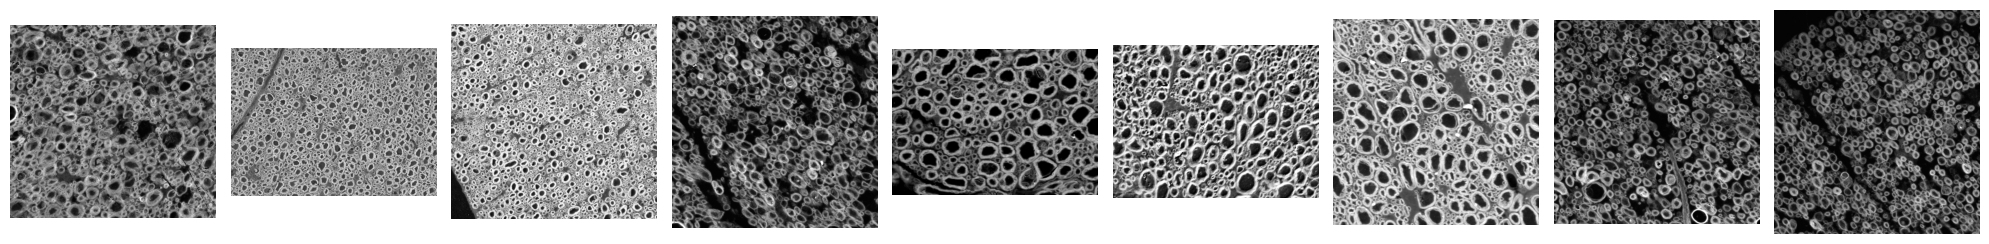

In [9]:
display(Markdown('# Input images'))
show_input_files(input_images_paths)

In [10]:
map_inputs = create_map_inputs(input_images_paths, input_metadata_paths)

In [11]:
map = tools.maps.oSparcFileMap(input1_dir_path/'output_tasks.json', output1_dir_path/'input_tasks.json', osparc_cfg)
map_outputs = map.evaluate(map_inputs)
map_outputs_file_path.write_text(json.dumps(map_outputs));

In [12]:
map_outputs = json.loads(map_outputs_file_path.read_text())

# Processed Images

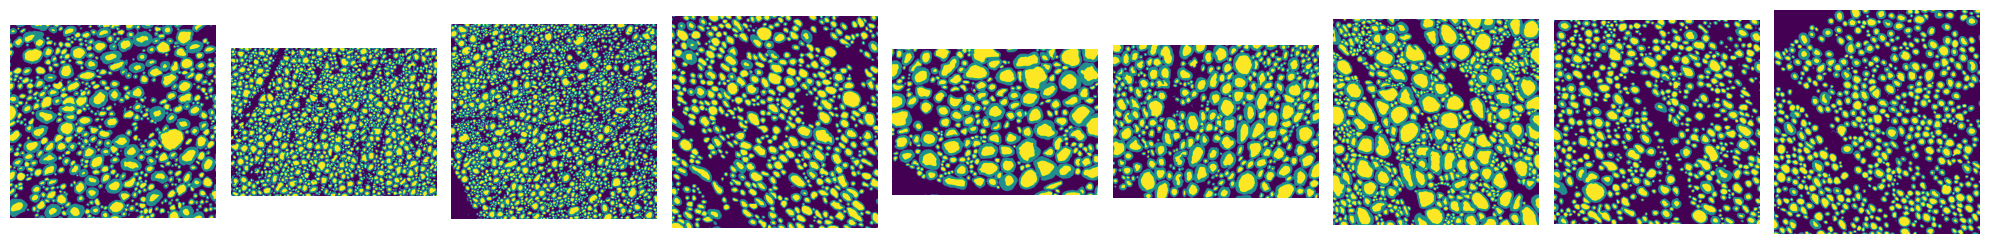

In [13]:
display(Markdown('# Processed Images'))
show_output_files(map_outputs, input_images_paths)

In [14]:
requested_morphometrics = ['axon_diam (um)', 'axon_area (um^2)', 'myelin_thickness (um)', 'myelin_area (um^2)']

# Output Morphometrics

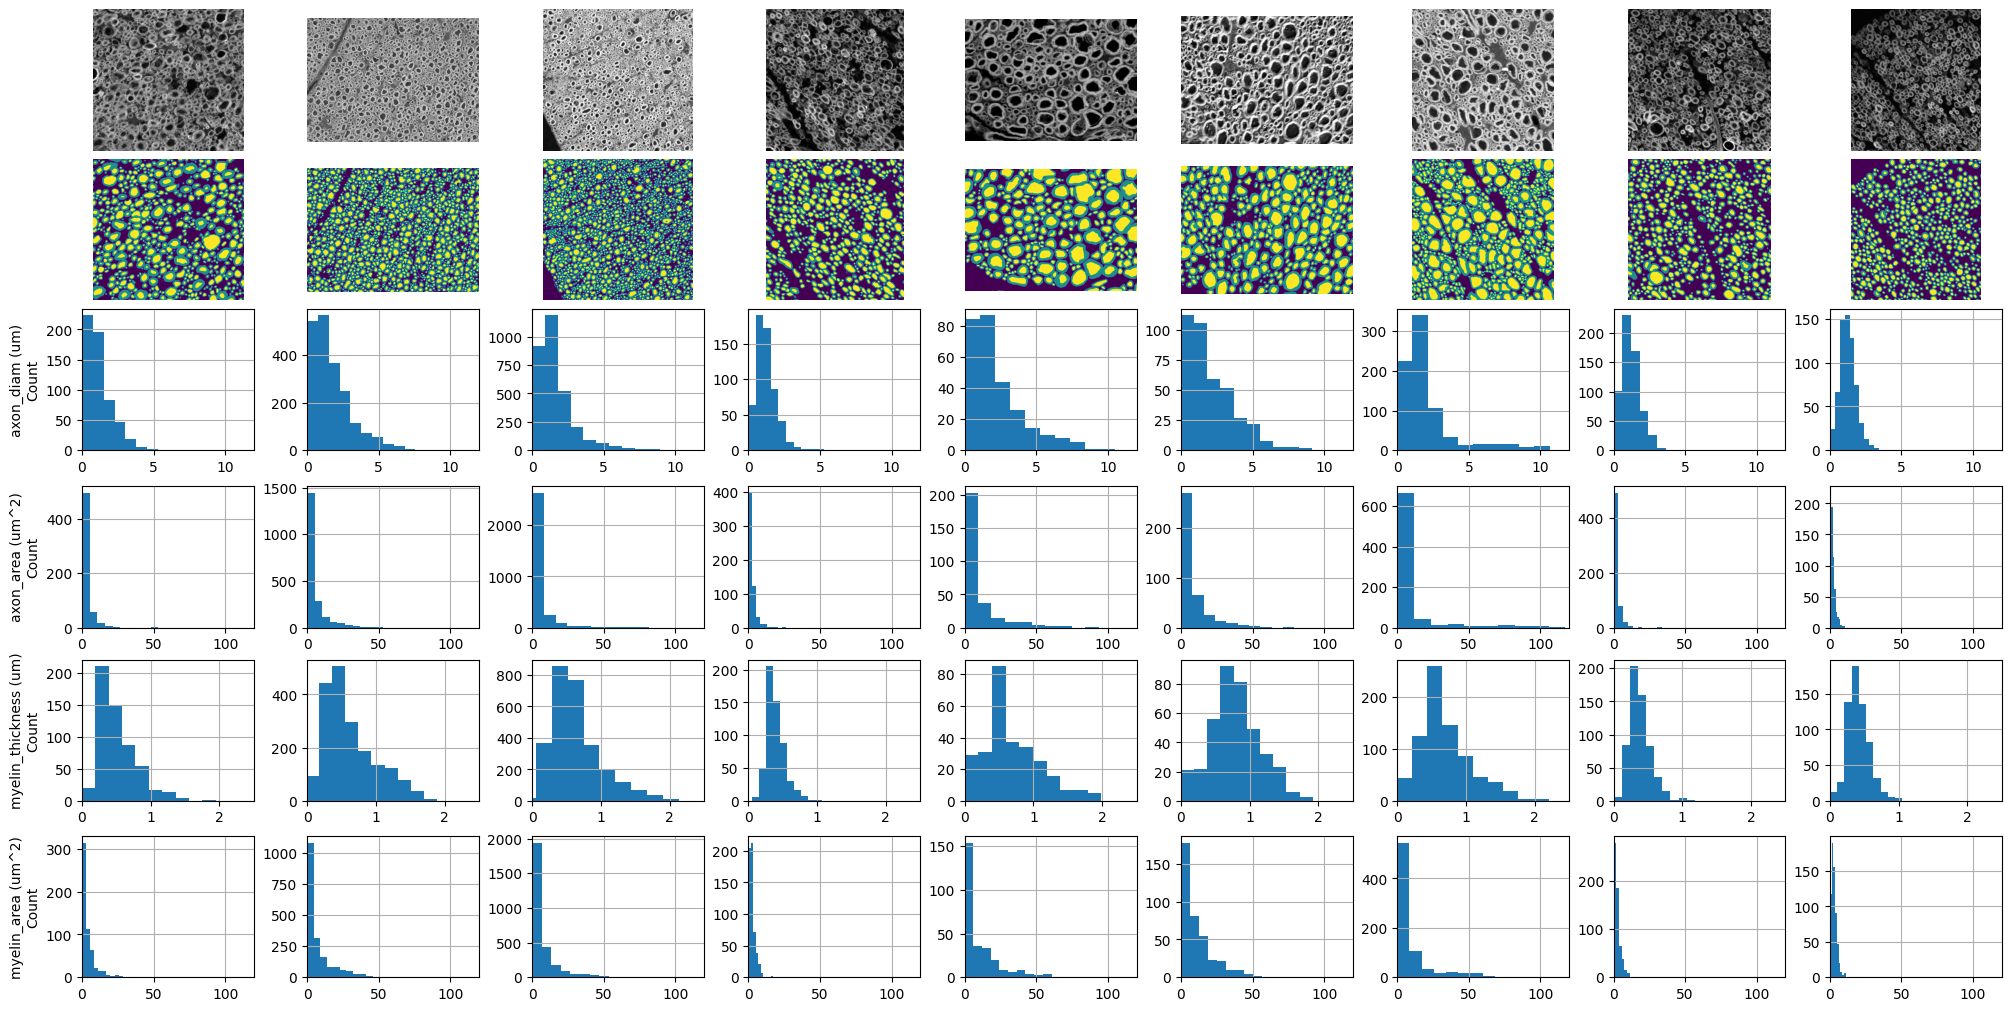

In [15]:
display(Markdown('# Output Morphometrics'))

fig, axes = plt.subplots(len(requested_morphometrics)+2, len(map_outputs), squeeze=False, figsize=(20,2*len(requested_morphometrics)+2), layout="constrained")
for i_axes, (map_output, input_image_path, ax) in enumerate(zip(map_outputs, input_images_paths, axes.transpose())):
    ax[0].imshow(mpimg.imread(input_image_path), cmap='gray')
    ax[0].axis('off')
    ax[0].autoscale(False)
    
    with zipfile.ZipFile(map_output['ProcessedImage']) as output_zip:
        processed_filename = f'{input_image_path.stem}_seg-axonmyelin{input_image_path.suffix}'
        with output_zip.open(processed_filename) as image_file:
            ax[1].imshow(mpimg.imread(image_file))
            ax[1].axis('off')
            ax[1].autoscale(False)
    
    morphometrics_file = map_output['Morphometrics']
    morphometrics = pandas.read_csv(morphometrics_file)
    for i_ax, requested_morphometric in enumerate(requested_morphometrics, 2):
        morphometrics.hist(column=requested_morphometric, ax=ax[i_ax])
        if i_axes == 0:
            ax[i_ax].set_ylabel(f'{requested_morphometric}\nCount')
        ax[i_ax].set_title('')
        if 'diam' in requested_morphometric:
            ax[i_ax].set_xlim(0,12)
        elif 'thickness' in requested_morphometric:
            ax[i_ax].set_xlim(0,2.5)
        elif 'area' in requested_morphometric:
            ax[i_ax].set_xlim(0,120)

plt.show()

# Summary Morphometrics

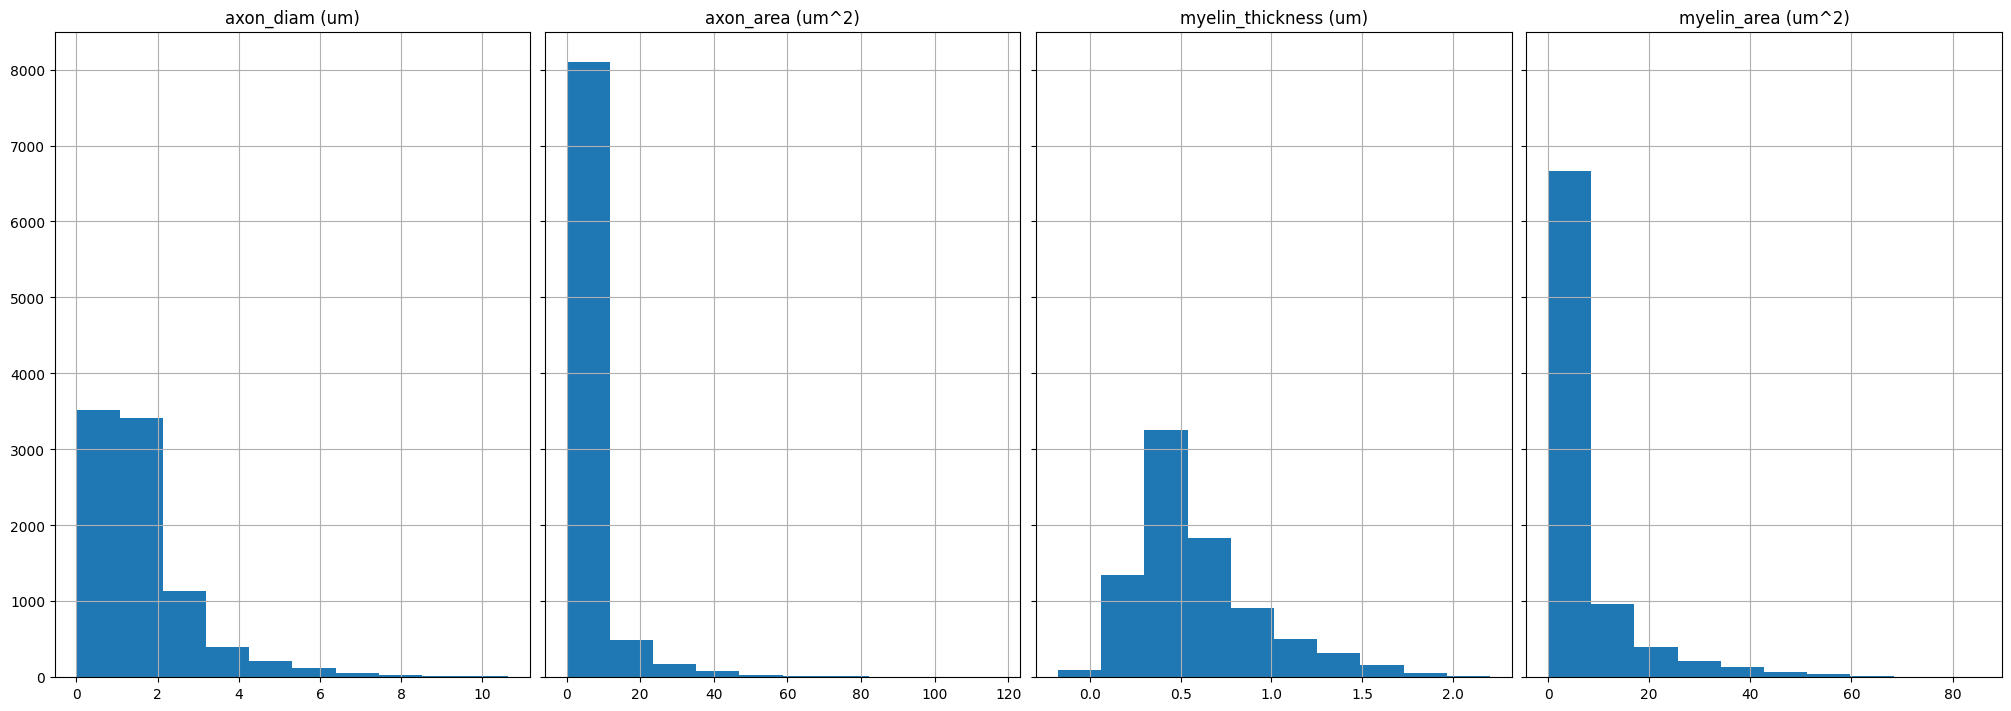

In [16]:
display(Markdown('# Summary Morphometrics'))

summary_data = pandas.concat([pandas.read_csv(map_output['Morphometrics']) for map_output in map_outputs], axis=0, ignore_index=True)

fig, axes = plt.subplots(1, len(requested_morphometrics), sharey=True, squeeze=False, figsize=(20,7), layout="constrained")

for requested_morphometric, ax in zip(requested_morphometrics, axes[0]):
    summary_data.hist(column=requested_morphometric, ax=ax)